<h1 style='color: blue; font-size: 34px; font-weight: bold;'> Modelo Econométrico para Plataforma Online
</h1>
<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i> </i> 
</p>  

# <font color='red' style='font-size: 40px;'> Library   </font>
<hr style='border: 2px solid red;'>

In [1]:

## Bibliotecas de Análise de Dados
import pandas as pd 
import builtins as builtins
import matplotlib.pyplot as plt
import seaborn as sns 
from IPython.display import display, Image
from tabulate import tabulate
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter

# Bibliotecas de Manipulação de Tempo
from datetime import datetime, date

## Bibliotecas de Modelagem Matemática e Estatística
import numpy as np
import scipy as sp 
import scipy.stats as stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import normaltest, ttest_ind, ttest_rel, mannwhitneyu, wilcoxon, kruskal, uniform, chi2_contingency
from statsmodels.stats.weightstats import ztest
from numpy import interp
import random

# Bibliotecas de Seleção de Modelos
from skopt import BayesSearchCV

# Bibliotecas de Pré-Processamento e Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

# Bibliotecas de Modelos de Machine Learning
import joblib
from joblib import Parallel, delayed
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Bibliotecas de Métricas de Machine Learning
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_score, recall_score, precision_recall_curve, average_precision_score, f1_score, log_loss, brier_score_loss, confusion_matrix, silhouette_score


# Parâmetros de Otimização
import random
import warnings
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = [10, 5]
pd.set_option('display.max_rows', 100) 
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Tira os números do formato de Notação Científica
np.set_printoptions(suppress=True) # Tira os números do formato de Notação Científica em Numpy Arrays
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # Retira Future Warnings
# from pyspark.sql import SparkSession, Row 
# from pyspark.sql.functions import *
# import pyspark.sql.functions as F
 

# # Spark Session
# spark = SparkSession.builder.getOrCreate()

In [2]:
def plota_barras(lista_variaveis, df, titulo, rotation=0):        
    k = 0
    # Ordena os dados para garantir que as labels correspondam corretamente às barras
    df_sorted = df[lista_variaveis[k]].value_counts().index
    ax = sns.countplot(x=lista_variaveis[k], data=df, order=df_sorted, color='#1FB3E5')
    
    ax.set_title(f'{titulo}')
    ax.set_xlabel(f'{lista_variaveis[k]}', fontsize=14)
    ax.set_ylabel('Quantidade', fontsize=14)
    
    # Calcular o total para obter os percentuais
    total = sum([p.get_height() for p in ax.patches])
    
    sizes = []
    for bar in ax.patches:
        height = bar.get_height()
        sizes.append(height)
        ax.text(bar.get_x() + bar.get_width()/2,
                height,
                f'{builtins.round((height/total)*100, 2)}%',
                ha='center',
                fontsize=12
        )
    
    ax.set_ylim(0, max(sizes) * 1.1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha='right', fontsize=10)
    ax.set_yticklabels(['{:,.0f}'.format(y) for y in ax.get_yticks()], fontsize=10)

    plt.tight_layout()
    plt.show()

def plota_grafico_linhas(df, x, y, nao_calcula_media, title):

    if nao_calcula_media:
        # Criando o gráfico de linha
        plt.figure(figsize=(10, 6))
        plt.plot(df[x], df[y], marker='o', linestyle='-', color='#1FB3E5')

        # Adicionando títulos e rótulos aos eixos
        plt.title(title)
        plt.xlabel(x)
        plt.ylabel(y)

        for i, txt in enumerate(df[y]):
            plt.annotate(f'{txt:.1f}', (df[x][i], df[y][i]), textcoords="offset points", xytext=(0,1), ha='center')

        # Exibindo o gráfico
        plt.grid(True)
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    else:
        media = df[y].mean()
        # Criando o gráfico de linha
        plt.figure(figsize=(10, 6))
        plt.plot(df[x], df[y], marker='o', linestyle='-', color='#1FB3E5')

        # Adicionando linha da média
        plt.axhline(y=media, color='r', linestyle='--', linewidth=1, label=f'Média: {media:.2f}')
        plt.legend()

        # Adicionando títulos e rótulos aos eixos
        plt.title(title)
        plt.xlabel(x)
        plt.ylabel(y)

        for i, txt in enumerate(df[y]):
            plt.annotate(f'{txt:.1f}', (df[x][i], df[y][i]), textcoords="offset points", xytext=(0,1), ha='center')

        # Exibindo o gráfico
        plt.grid(True)
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

In [3]:
def analisa_distribuicao_via_percentis(df, variaveis):
    def sublinha_percentis(s):
        is_1_percentile = s.name == '1%'
        is_99_8_percentile = s.name == '99%'
        if is_1_percentile or is_99_8_percentile:
            return ['background-color: blue'] * len(s)
        else:
            return [''] * len(s)

    percentis = df[variaveis].describe(percentiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]).style.apply(sublinha_percentis, axis=1)    

    return percentis

In [4]:
def compara_medias_amostras(df, variaveis_continuas, target):  
    num_variaveis = len(variaveis_continuas)
    num_pares = (num_variaveis + 1) // 2  # Número de pares de variáveis para subplots
    fig, axes = plt.subplots(num_pares, 2, figsize=(14, 4 * num_pares))

    # Ajusta para o caso onde há apenas uma variável
    if num_pares == 1:
        axes = np.expand_dims(axes, axis=0)
    
    for i in range(num_pares):
        if 2 * i < num_variaveis:
            variavel1 = variaveis_continuas[2 * i]
            percentis1 = df[variavel1].describe(percentiles=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])
            p1_1 = percentis1['1%']
            p99_1 = percentis1['99%']
            df_raw1 = df.loc[(df[variavel1] > p1_1) & (df[variavel1] < p99_1)].copy()
            df_com_bad1 = df_raw1.loc[df_raw1[target] == 1]
            df_sem_bad1 = df_raw1.loc[df_raw1[target] == 0]
            
            medias_amostrais_com_bad1 = []
            medias_amostrais_sem_bad1 = []
            
            for j in range(5000):
                amostra_bad1 = random.choices(df_com_bad1[variavel1].values, k=1000)
                media_amostra_bad1 = np.mean(amostra_bad1)
                medias_amostrais_com_bad1.append(media_amostra_bad1)

                amostra_sem_bad1 = random.choices(df_sem_bad1[variavel1].values, k=1000)
                media_amostra_sem_bad1 = np.mean(amostra_sem_bad1)
                medias_amostrais_sem_bad1.append(media_amostra_sem_bad1)

            ax_hist1 = axes[i, 0]
            ax_hist1.hist(medias_amostrais_com_bad1, bins=30, alpha=0.5, label='bad', linewidth=5, color="red")
            ax_hist1.hist(medias_amostrais_sem_bad1, bins=30, alpha=0.5, label='Sem bad', linewidth=5, color="green")
            ax_hist1.legend(loc='upper right')
            ax_hist1.set_xlabel('Valores')
            ax_hist1.set_ylabel('Frequência')
            ax_hist1.set_title(f'Distribuição das Médias Amostrais de "{variavel1}" ')
            ax_hist1.grid(True)
        
        if 2 * i + 1 < num_variaveis:
            variavel2 = variaveis_continuas[2 * i + 1]
            percentis2 = df[variavel2].describe(percentiles=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])
            p1_2 = percentis2['1%']
            p99_2 = percentis2['99%']
            df_raw2 = df.loc[(df[variavel2] > p1_2) & (df[variavel2] < p99_2)].copy()
            df_com_bad2 = df_raw2.loc[df_raw2[target] == 1]
            df_sem_bad2 = df_raw2.loc[df_raw2[target] == 0]
            
            medias_amostrais_com_bad2 = []
            medias_amostrais_sem_bad2 = []
            
            for j in range(5000):
                amostra_bad2 = random.choices(df_com_bad2[variavel2].values, k=1000)
                media_amostra_bad2 = np.mean(amostra_bad2)
                medias_amostrais_com_bad2.append(media_amostra_bad2)

                amostra_sem_bad2 = random.choices(df_sem_bad2[variavel2].values, k=1000)
                media_amostra_sem_bad2 = np.mean(amostra_sem_bad2)
                medias_amostrais_sem_bad2.append(media_amostra_sem_bad2)

            ax_hist2 = axes[i, 1]
            ax_hist2.hist(medias_amostrais_com_bad2, bins=30, alpha=0.5, label='bad', linewidth=5, color="red")
            ax_hist2.hist(medias_amostrais_sem_bad2, bins=30, alpha=0.5, label='Sem bad', linewidth=5, color="green")
            ax_hist2.legend(loc='upper right')
            ax_hist2.set_xlabel('Valores')
            ax_hist2.set_ylabel('Frequência')
            ax_hist2.set_title(f'Distribuição das Médias Amostrais de "{variavel2}" ')
            ax_hist2.grid(True)

    plt.tight_layout()
    plt.show()


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_histogram_and_boxplot(df, variavel, target):
    """
    Cria dois gráficos lado a lado:
    - Esquerda: Histogramas da variável separados pela target, representados como linhas (sem preenchimento).
    - Direita: Boxplots da variável separados pela target.
    
    Parâmetros:
    - df: DataFrame contendo os dados.
    - variavel: Nome da variável a ser analisada.
    - target: Nome da variável target que separa os grupos.
    """
    # Configuração do tamanho da figura
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Gráfico 1: Histogramas como linhas
    for label, color in zip(df[target].unique(), ['blue', 'orange']):
        subset = df[df[target] == label]
        axes[0].hist(
            subset[variavel], 
            bins=30, 
            color=color, 
            label=f'{label}', 
            histtype='step',  # Define o histograma como linha
            density=True,    # Normaliza para densidade
            linewidth=2       # Espessura da linha
        )
    axes[0].set_title(f'Distribuição de Bons e Maus para {variavel}', fontsize=12)
    axes[0].set_xlabel(variavel)
    axes[0].set_ylabel('Densidade')
    axes[0].legend(title=target)
    
    # Gráfico 2: Boxplots
    sns.boxplot(x=target, y=variavel, data=df, ax=axes[1], palette=['blue', 'orange'])
    axes[1].set_title(f'Boxplot de Bons e Maus para {variavel}', fontsize=12)
    axes[1].set_xlabel(target)
    axes[1].set_ylabel(variavel)

    # Ajuste da disposição dos gráficos
    plt.tight_layout()
    plt.show()

In [6]:
def transform_to_deciles(df, variavel_continua):
    # Calcula os limites dos deciles
    decile_limits = [i / 10 for i in range(11)]  # [0.0, 0.1, 0.2, ..., 1.0]
    
    # Aplica a função qcut para transformar a variável em deciles
    deciles = pd.qcut(df[variavel_continua], q=10, labels=False, duplicates='drop')
    
    return deciles

In [7]:
def woe(df, feature, target):
    mau = df.loc[df[target] == 1].groupby(feature, as_index = False)[target].count().rename({target:'mau'}, axis = 1)
    sem_mau = df.loc[df[target] == 0].groupby(feature, as_index = False)[target].count().rename({target:'sem_mau'}, axis = 1)

    woe = mau.merge(sem_mau, on = feature, how = 'outer').fillna(0)
    woe['percent_mau'] = woe['mau']/woe['mau'].sum()
    woe['percent_sem_mau'] = woe['sem_mau']/woe['sem_mau'].sum()
    woe['woe'] = round(np.log(woe['percent_mau']/woe['percent_sem_mau']), 3)
    woe.sort_values(by = 'woe', ascending = True, inplace = True)

    weight_of_evidence = woe['woe'].unique()


    x = list(woe[feature])
    y = list(woe['woe'])

    plt.figure(figsize=(10, 4))
    plt.plot(x, y, marker='o', linestyle='--', linewidth=2, color='#1FB3E5')

    for label, value in zip(x, y):
        plt.text(x=label, y=value, s=str(value), fontsize=10, color='red', ha='left', va='center', rotation=45)

    plt.title(f'Weight of Evidence da variável "{feature}"', fontsize=14)
    plt.xlabel('Classes', fontsize=14)
    plt.ylabel('Weight of Evidence', fontsize=14)
    plt.xticks(ha='right', fontsize=10, rotation=45)
    plt.show()

In [8]:
def iv(df, feature, target):
    bad = df.loc[df[target] == 1].groupby(feature, as_index = False)[target].count().rename({target:'bad'}, axis = 1)
    good = df.loc[df[target] == 0].groupby(feature, as_index = False)[target].count().rename({target:'good'}, axis = 1)
    
    woe = good.merge(bad, on = feature, how = 'outer').fillna(0)
    woe['percent_bad'] = woe['bad']/woe['bad'].sum()
    woe['percent_good'] = woe['good']/woe['good'].sum()
    woe['woe'] = round(np.log(woe['percent_bad']/woe['percent_good']), 3)
    woe.sort_values(by = 'woe', ascending = True, inplace = True)
    woe['iv'] = ((woe['percent_bad'] - woe['percent_good'])*np.log(woe['percent_bad']/woe['percent_good'])).sum()

    woe['woe'].fillna(0, inplace = True)
    woe['iv'].fillna(0, inplace = True)

    weight_of_evidence = woe['woe'].unique()
    iv = round(woe['iv'].max(), 2)

    dicionario = {feature:iv}

    iv_df = pd.DataFrame(list(dicionario.items()), columns=['Feature', 'IV'])
    
    return iv_df

In [9]:
def separa_feature_target(target, dados):
    x = dados.drop(target, axis = 1)
    y = dados[[target]]

    return x, y

def train_min_max_scaler(df):

    cols = list(df.drop(['id_registro', 'aprovado', 'mau'], axis = 1).columns)

    df_scaler = df[cols].copy()

    scaler = MinMaxScaler()
    scaler.fit(df_scaler)
    joblib.dump(scaler, "../models/scaler.pkl")
    print('Scaler Treinado e Salvo com sucesso!')

def Classificador(classificador, x_train, y_train, x_test, y_test, class_weight):

    # Puxa o Scaler Treinado com os dados de Treino
    scaler = joblib.load("../models/scaler.pkl")
    
    cols = list(x_train.drop(['id_registro', 'aprovado'], axis = 1).columns)

    x_train = x_train[cols]
    x_test = x_test[cols]

    # Define as colunas categóricas e numéricas
    models = {
        'Regressão Logística': make_pipeline(
            ColumnTransformer([
                ('scaler', make_pipeline(scaler), cols)
            ]),
            LogisticRegression(
                random_state=42, # Semente aleatória para reproducibilidade dos resultados
                class_weight={0: 1, 1: class_weight}, # Peso atribuído às classes. Pode ser útil para lidar com conjuntos de dados desbalanceados.
                C=1, # Parâmetro de regularização inversa. Controla a força da regularização.
                penalty='l2', # Tipo de regularização. 'l1', 'l2', 'elasticnet', ou 'none'.
                max_iter=50, # Número máximo de iterações para a convergência do otimizador.
                solver='liblinear' # Algoritmo de otimização. 'newton-cg', 'lbfgs', 'liblinear' (gradiente descendente), 'sag' (Stochastic gradient descent), 'saga' (Stochastic gradient descent que suporta reg L1).
                )
        )
    }

    if classificador in models:
        model = models[classificador]
    else:
        print('Utilize Regressão Logística, Random Forest ou XGBoost como opções de Classificadores!')

    model.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    y_proba_train = model.predict_proba(x_train)
    y_proba_test = model.predict_proba(x_test)

    return model, y_pred_train, y_pred_test, y_proba_train, y_proba_test

def metricas_classificacao(classificador, y_train, y_predict_train, y_test, y_predict_test, y_predict_proba_train, y_predict_proba_test, etapa_1, etapa_2):

    predict_proba_train = pd.DataFrame(y_predict_proba_train.tolist(), columns=['predict_proba_0', 'predict_proba_1'])
    predict_proba_test = pd.DataFrame(y_predict_proba_test.tolist(), columns=['predict_proba_0', 'predict_proba_1'])

    # Treino
    accuracy_train = accuracy_score(y_train, y_predict_train)
    precision_train = precision_score(y_train, y_predict_train)
    recall_train = recall_score(y_train, y_predict_train)
    f1_train = f1_score(y_train, y_predict_train)
    roc_auc_train = roc_auc_score(y_train['mau'], predict_proba_train['predict_proba_1'])
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train['mau'], predict_proba_train['predict_proba_1'])
    ks_train = max(tpr_train - fpr_train)
    logloss_train = log_loss(y_train['mau'], predict_proba_train['predict_proba_1'])
    metricas_treino = pd.DataFrame(
        {
            'Acuracia': accuracy_train, 
            'Precisao': precision_train, 
            'Recall': recall_train, 
            'F1-Score': f1_train, 
            'AUC': roc_auc_train, 
            'KS': ks_train, 
            'LogLoss':logloss_train,
            'Etapa': etapa_1, 
            'Classificador': classificador
        }, 
        index=[0]
    )
    
    # Teste
    accuracy_test = accuracy_score(y_test, y_predict_test)
    precision_test = precision_score(y_test, y_predict_test)
    recall_test = recall_score(y_test, y_predict_test)
    f1_test = f1_score(y_test, y_predict_test)
    roc_auc_test = roc_auc_score(y_test['mau'], predict_proba_test['predict_proba_1'])
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test['mau'], predict_proba_test['predict_proba_1'])
    ks_test = max(tpr_test - fpr_test)
    logloss_test = log_loss(y_test['mau'], predict_proba_test['predict_proba_1'])
    metricas_teste = pd.DataFrame(
        {
            'Acuracia': accuracy_test, 
            'Precisao': precision_test, 
            'Recall': recall_test, 
            'F1-Score': f1_test, 
            'AUC': roc_auc_test, 
            'KS': ks_test, 
            'LogLoss':logloss_test,
            'Etapa': etapa_2, 
            'Classificador': classificador
        }, 
        index=[0]
    )
    
    # Consolidando
    metricas_finais = pd.concat([metricas_treino, metricas_teste])

    return metricas_finais


def metricas_classificacao_modelos_juntos(lista_modelos):
    if len(lista_modelos) > 0:
        metricas_modelos = pd.concat(lista_modelos)#.set_index('Classificador')
    else:
        metricas_modelos = lista_modelos[0]
    # Redefina o índice para torná-lo exclusivo
    df = metricas_modelos.reset_index(drop=True)
    df = df.round(2)

    # Função para formatar as células com base na Etapa
    def color_etapa(val):
        color = 'black'
        if val == 'treino':
            color = 'blue'
        elif val == 'teste':
            color = 'red'
        return f'color: {color}; font-weight: bold;'

    # Função para formatar os valores com até duas casas decimais
    def format_values(val):
        if isinstance(val, (int, float)):
            return f'{val:.2f}'
        return val

    # Estilizando o DataFrame
    styled_df = df.style\
        .format(format_values)\
        .applymap(lambda x: 'color: black; font-weight: bold; background-color: white; font-size: 14px', subset=pd.IndexSlice[:, :])\
        .applymap(color_etapa, subset=pd.IndexSlice[:, :])\
        .applymap(lambda x: 'color: black; font-weight: bold; background-color: #white; font-size: 14px', subset=pd.IndexSlice[:, 'Acuracia':'F1-Score'])\
        .applymap(lambda x: 'color: black; font-weight: bold; background-color: #white; font-size: 14px', subset=pd.IndexSlice[:, 'Etapa'])\
        .set_table_styles([
            {'selector': 'thead', 'props': [('color', 'black'), ('font-weight', 'bold'), ('background-color', 'lightgray')]}
        ])

    # Mostrando o DataFrame estilizado
    styled_df
    return styled_df

# <font color='red' style='font-size: 40px;'> 1. Leitura do Dataset </font>
<hr style='border: 2px solid red;'>

https://www.kaggle.com/datasets/nosbielcs/brazilian-delivery-center?resource=download

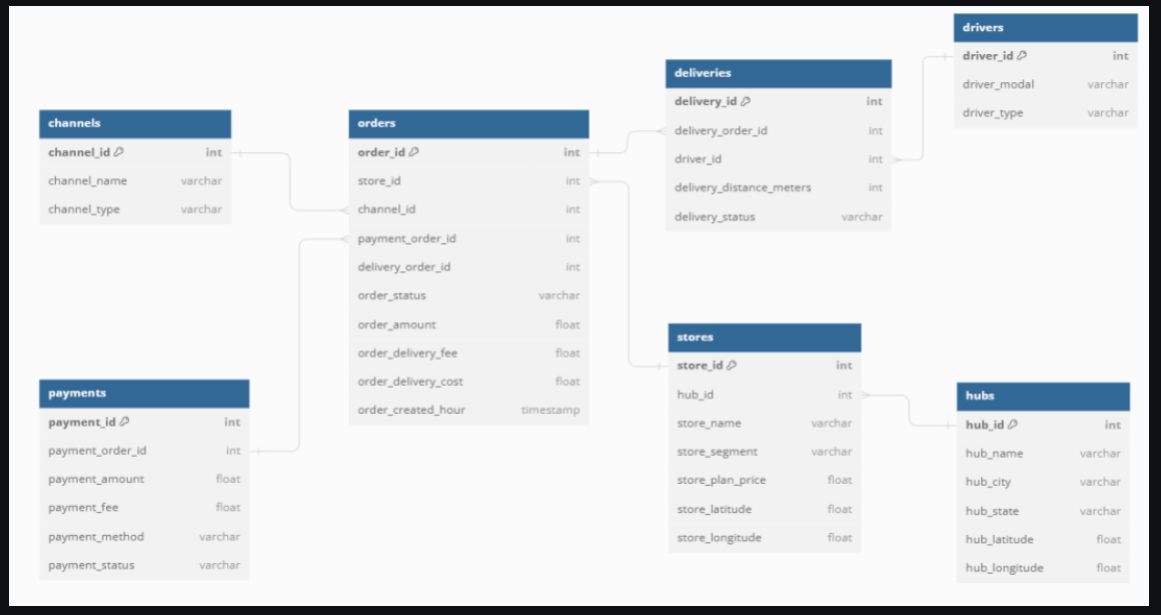

# <font color='green' style='font-size: 30px;'> 1.1) Objetivos </font>
<hr style='border: 2px solid green;'>

### 1) Descrição


### 2) Desafios


In [10]:
df_metaverse = pd.read_csv('../data/metaverse_transactions_dataset.csv')
df_metaverse = (
    df_metaverse
        .rename(
            columns=
            {
                'timestamp':'data_hora_transacao', 
                'hour_of_day':'hora_transacao', 
                'sending_address':'id_enviador', 
                'receiving_address':'id_recebedor',
                'amount':'valor_transacao', 
                'transaction_type':'tipo_transacao', 
                'location_region':'regiao_geografica', 
                'ip_prefix':'prefixo_ip',
                'login_frequency':'frequencia_login', 
                'session_duration':'duracao_sessao_atividade', 
                'purchase_pattern':'padrao_comportamental_de_compras', 
                'age_group':'recencia_atividade',
                'risk_score':'risk_score', 
                'anomaly':'risk_rank',
            }
        )
)
# df_metaverse['data'] = df_metaverse['data_hora_transacao'].apply(lambda x:x[:10])
df_metaverse['safra'] = df_metaverse['data_hora_transacao'].apply(lambda x:x[:7])
# df_metaverse['dia'] = df_metaverse['data_hora_transacao'].apply(lambda x:x[8:10])
df_metaverse['risk_client'] = np.where(df_metaverse['risk_rank'] == 'high_risk', 1, 0)
df_metaverse['transacao'] = 1
df_metaverse = (
    df_metaverse
        [[
            'safra', 'id_enviador','id_recebedor', 'transacao', 'hora_transacao',
            'valor_transacao', 'tipo_transacao','regiao_geografica', 'prefixo_ip', 'frequencia_login',
            'duracao_sessao_atividade', 'padrao_comportamental_de_compras','recencia_atividade', 'risk_score', 'risk_rank', 'risk_client'
        ]]
        .sort_values(by = ['safra','id_enviador', 'id_recebedor'], ascending = True)
)

df_metaverse

,safra,id_enviador,id_recebedor,transacao,hora_transacao,valor_transacao,tipo_transacao,regiao_geografica,prefixo_ip,frequencia_login,duracao_sessao_atividade,padrao_comportamental_de_compras,recencia_atividade,risk_score,risk_rank,risk_client
28911,2022-01,0x00262fa3b21847775e2db42965d0192e8dfe5bdc,0x757e936769ebc13de3e88f783169b547e76c1f84,1,4,295.94,transfer,Asia,172.00,4,75,focused,established,20.25,low_risk,0
34331,2022-01,0x00262fa3b21847775e2db42965d0192e8dfe5bdc,0x757e936769ebc13de3e88f783169b547e76c1f84,1,12,669.19,purchase,South America,172.00,3,64,focused,established,26.25,low_risk,0
42461,2022-01,0x00262fa3b21847775e2db42965d0192e8dfe5bdc,0x757e936769ebc13de3e88f783169b547e76c1f84,1,5,158.15,purchase,North America,10.00,3,69,focused,established,33.75,low_risk,0
50591,2022-01,0x00262fa3b21847775e2db42965d0192e8dfe5bdc,0x757e936769ebc13de3e88f783169b547e76c1f84,1,13,404.26,sale,South America,192.17,2,20,random,new,42.00,low_risk,0
66851,2022-01,0x00262fa3b21847775e2db42965d0192e8dfe5bdc,0x757e936769ebc13de3e88f783169b547e76c1f84,1,16,460.36,purchase,Asia,172.00,2,27,random,new,36.75,low_risk,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11332,2022-12,0xfff61889339b01858cc0b3034ecc59aa7f47db25,0xe0194b2da8b9504f85a39a1b07ad9faabf7d1244,1,17,431.58,purchase,Europe,172.00,2,30,random,new,36.75,low_risk,0
14042,2022-12,0xfff61889339b01858cc0b3034ecc59aa7f47db25,0xe0194b2da8b9504f85a39a1b07ad9faabf7d1244,1,21,511.59,purchase,Africa,192.00,2,26,random,new,36.75,low_risk,0
46562,2022-12,0xfff61889339b01858cc0b3034ecc59aa7f47db25,0xe0194b2da8b9504f85a39a1b07ad9faabf7d1244,1,3,532.05,purchase,Africa,192.17,1,22,random,new,49.61,low_risk,0
54692,2022-12,0xfff61889339b01858cc0b3034ecc59aa7f47db25,0xe0194b2da8b9504f85a39a1b07ad9faabf7d1244,1,2,479.37,purchase,Europe,192.00,4,45,focused,established,35.44,low_risk,0


# <font color='red' style='font-size: 40px;'> 2. Análise da Target </font>
<hr style='border: 2px solid red;'>

# <font color='green' style='font-size: 30px;'> 2.1) Target - Risk Score, Risk Rank e Risk Clients </font>
<hr style='border: 2px solid green;'>

> 1. Temos 80% dos casos como Baixo Risco, 11% como Risco Moderado e 8% como Alto Risco

> 2. O Baixo Risco vai do Score 0 ao 60; o Risco Moderado do Score 60 ao 75 (mais ou menos) e o Alto Risco do Score 75 pra cima

> 3. A distribuição de Clientes Arriscados é relativamente estável ao longo do tempo, sem mudanças muito abruptas

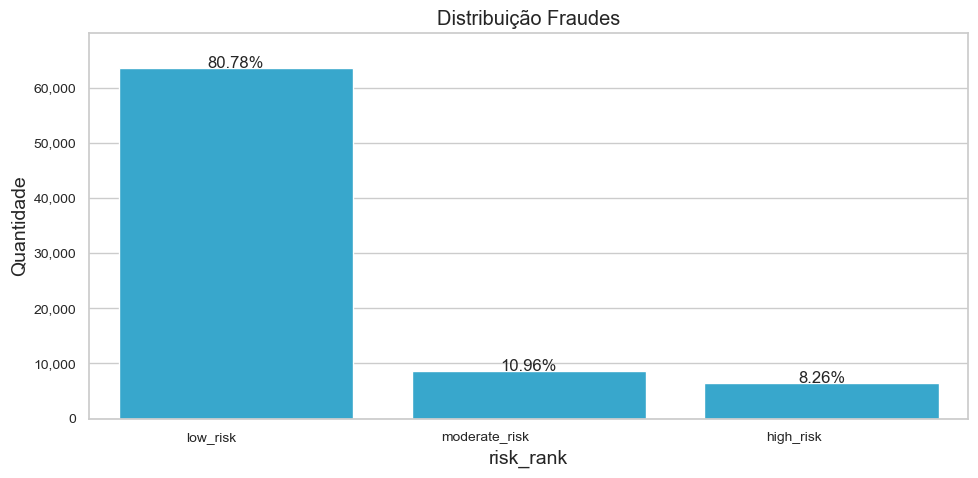

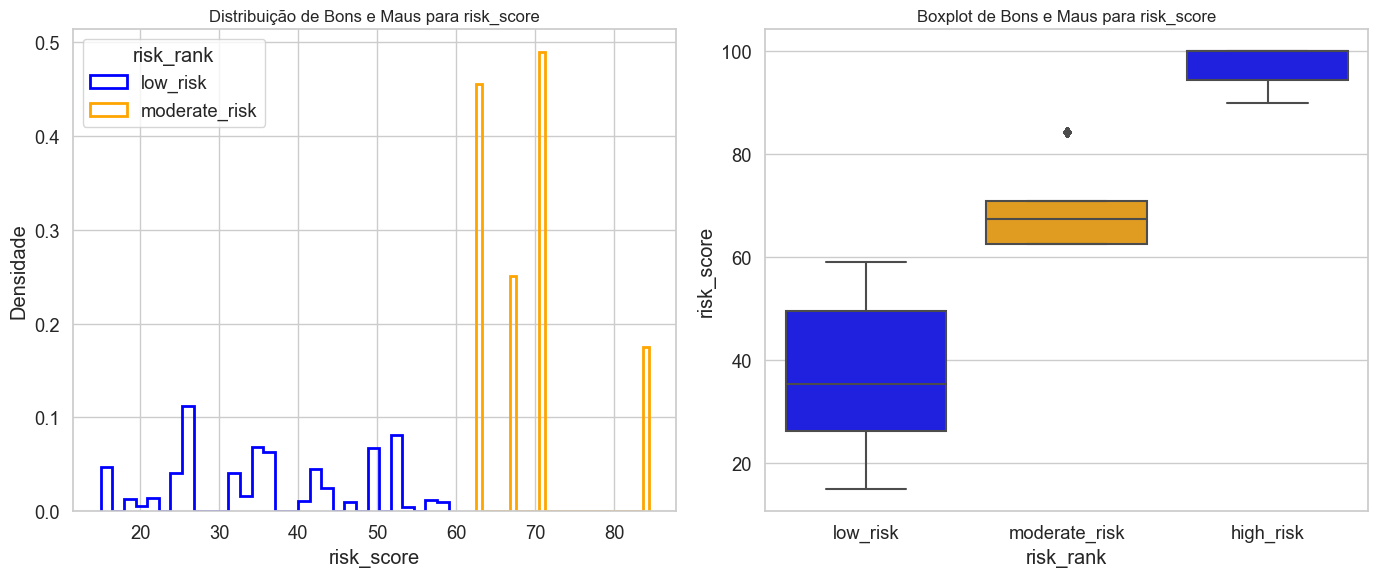

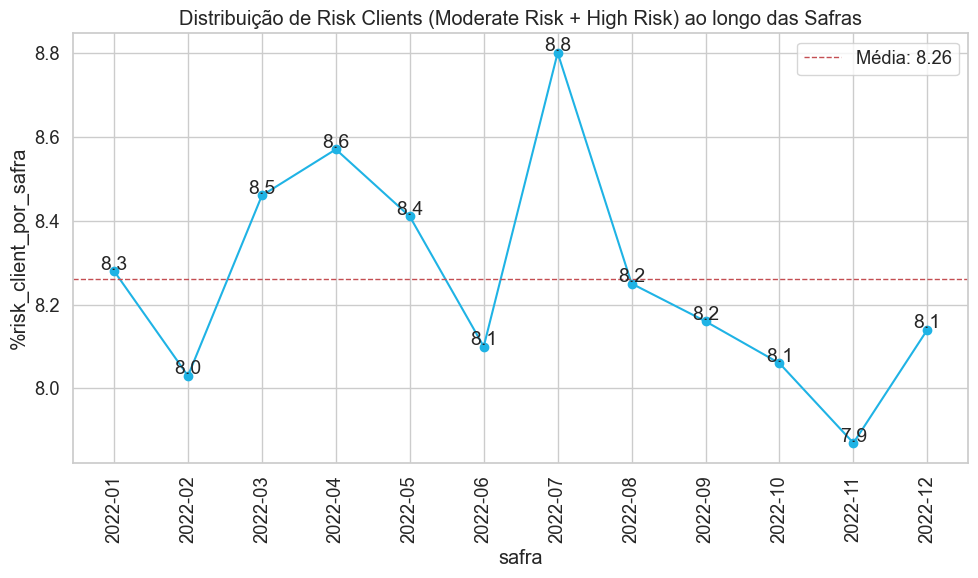

In [13]:
# Distribuição de Risk Rank
plota_barras(['risk_rank'], df_metaverse, 'Distribuição Fraudes', rotation=0)


# Risk Score vs Risk Rank
plot_histogram_and_boxplot(df_metaverse, 'risk_score', 'risk_rank')

# Risk Client Vs Safra
risk_client_por_safra = df_metaverse[["id_enviador", "safra", "risk_client"]].groupby("safra").agg({"risk_client":"sum", "id_enviador":"count"}).reset_index()
risk_client_por_safra["%risk_client_por_safra"] = round(risk_client_por_safra["risk_client"]/risk_client_por_safra["id_enviador"]*100, 2)
plota_grafico_linhas(risk_client_por_safra, "safra", "%risk_client_por_safra", False, "Distribuição de Risk Clients (Moderate Risk + High Risk) ao longo das Safras")

# <font color='green' style='font-size: 30px;'> 2.2) Separação de Amostras para Treino, Teste e OOT </font>
<hr style='border: 2px solid green;'>


# <font color='red' style='font-size: 40px;'> 3. Análise Exploratória </font>
<hr style='border: 2px solid red;'>

# <font color='green' style='font-size: 30px;'> 3.1) Tipo de Dados </font>
<hr style='border: 2px solid green;'>

In [18]:
df_metaverse.dtypes

safra                                object
id_enviador                          object
id_recebedor                         object
transacao                             int64
hora_transacao                        int64
valor_transacao                     float64
tipo_transacao                       object
regiao_geografica                    object
prefixo_ip                          float64
frequencia_login                      int64
duracao_sessao_atividade              int64
padrao_comportamental_de_compras     object
recencia_atividade                   object
risk_score                          float64
risk_rank                            object
risk_client                           int32
dtype: object

# <font color='green' style='font-size: 30px;'> 3.2) Nulos </font>
<hr style='border: 2px solid green;'>

In [ ]:
df_nulls = (
    pd.DataFrame(
        df_metaverse
        # .drop(["msno", "safra", "churn"] + variaveis_desconsideradas, axis = 1)
        .isnull().sum()
      )
      .reset_index()
      .rename({0:'nulls_amnt'}, axis = 1)
)
df_nulls['nulls_rate'] = round((df_nulls['nulls_amnt']/df_metaverse.shape[0])*100, 2)

print(f'Existem {len(df_nulls)} variáveis no Dataset')
df_not_nulls_nulls = df_nulls.loc[df_nulls['nulls_rate'] == 0]
columns_not_nulls = list(df_not_nulls_nulls['index'])
print(f'Existem {len(columns_not_nulls)} variáveis sem registros nulos no Dataset')

plota_grafico_linhas(df_nulls, "index", "nulls_rate", True, "Distribuição da Taxa de Instâncias Nulas para cada Variável")